In [1]:
# Plot in vivo spectrum data from the Shimadzu UV-1800
# Jackson M. Tsuji, 2022

In [2]:
import pandas as pd
from plotnine import *
import os

In [3]:
def read_shimadzu_csv_spectra(filepath, sample_name, normalize_chlorosome=False, start_nm=None, end_nm=None, multiplier=1, offset=0, set_zero=None):
    
    spectrum_data = pd.read_csv(filepath, sep=',', skiprows=1)\
      .rename(columns={'WL/nm': 'Wavelength (nm)', 'Abs':'Absorbance'})
    
    spectrum_data['Sample'] = sample_name
    
    if start_nm is not None:
        spectrum_data = spectrum_data[spectrum_data['Wavelength (nm)'] >= start_nm]
    
    if end_nm is not None:
        spectrum_data = spectrum_data[spectrum_data['Wavelength (nm)'] <= end_nm]
        
    if set_zero == 'Right':
        zero_wavelength = spectrum_data['Wavelength (nm)'].max()
        zero_target = float(spectrum_data[spectrum_data['Wavelength (nm)'] == zero_wavelength]['Absorbance']) # TODO confirm length is 1
        spectrum_data['Absorbance'] = spectrum_data['Absorbance'] - zero_target
        
    if set_zero == 'Linear':
        # y = mx+b
        left_wavelength = spectrum_data['Wavelength (nm)'].min()
        left_abs = float(spectrum_data[spectrum_data['Wavelength (nm)'] == left_wavelength]['Absorbance']) # TODO confirm length is 1
        
        right_wavelength = spectrum_data['Wavelength (nm)'].max()
        right_abs = float(spectrum_data[spectrum_data['Wavelength (nm)'] == right_wavelength]['Absorbance']) # TODO confirm length is 1
        
        slope = (right_abs - left_abs) / (right_wavelength - left_wavelength)
        yint = left_abs - slope * left_wavelength
        
        normalized_ys = []
        for index, row in spectrum_data.iterrows():
            x = float(row['Wavelength (nm)'])
            y = float(row['Absorbance'])
            expected_y = slope * x + yint
            normalized_y = y - expected_y
            normalized_ys.append(normalized_y)
        
        spectrum_data['Absorbance'] = normalized_ys
    
    if normalize_chlorosome is True:
        spectrum_data_chlorosome = spectrum_data[(spectrum_data['Wavelength (nm)'] > 700) & (spectrum_data['Wavelength (nm)'] < 800)]
        chlorosome_peak_height = spectrum_data_chlorosome['Absorbance'].max()
        chlorosome_peak_location = spectrum_data_chlorosome[spectrum_data_chlorosome['Absorbance'] == chlorosome_peak_height]['Wavelength (nm)'].to_list()[0]
        
        print('Normalizing sample "' + sample_name + '" to chlorosome peak height ' + str(chlorosome_peak_height) + ' at wavelength ' + str(chlorosome_peak_location))
        spectrum_data['Absorbance'] = spectrum_data['Absorbance'] / chlorosome_peak_height
    
    spectrum_data['Absorbance'] = spectrum_data['Absorbance'] * multiplier + offset
    
    return(spectrum_data)

In [4]:
metadata = pd.read_csv('metadata.tsv', sep='\t')\
  .rename(columns={'Sample-id':'Sample'})
metadata.head()

,Sample,Treatment,Replicate
0,A4,Light + Fe,A
1,A2,Light + Fe,B
2,A3,Light + Fe,C
3,B1,Fe (dark),A
4,B2,Fe (dark),B


In [5]:
# Load
all_spectra_list = []

for sample in metadata['Sample']:
    #print('Loading ' + sample)
    
    spectrum = read_shimadzu_csv_spectra(os.path.join('input', sample + '.csv'), sample, normalize_chlorosome=False, start_nm=650, end_nm=850, set_zero=None)
    all_spectra_list.append(spectrum)

spectrum_data = pd.concat(all_spectra_list)
spectrum_data.head()

,Wavelength (nm),Absorbance,Sample
50,850.0,0.019,A4
51,849.0,0.019,A4
52,848.0,0.019,A4
53,847.0,0.019,A4
54,846.0,0.019,A4


In [6]:
# Prepare to plot
plotting_data = spectrum_data\
  .merge(metadata, on='Sample', how='left')

# Note that only acetate treatments will be plotted. 
# The Fe only treatments had much lower signal intensity, and this may have been due to allowing the cultures to grow a bit too long or other factors. See the Nature Reporting Summary for more.
plotting_data = plotting_data[plotting_data['Treatment'].isin(['Light + Fe + acetate', 'Fe + acetate (dark)'])]
plotting_data['Treatment'] = plotting_data['Treatment'].map({'Light + Fe + acetate': 'Fe(II) + Ac (light)',
                                                             'Fe + acetate (dark)': 'Fe(II) + Ac (dark)'})

plotting_data['Treatment'] = pd.Categorical(plotting_data['Treatment'], 
                                            categories=plotting_data['Treatment'].unique(), ordered=True)

plotting_data.head()

,Wavelength (nm),Absorbance,Sample,Treatment,Replicate
1206,850.0,0.055,C1,Fe(II) + Ac (light),A
1207,849.0,0.055,C1,Fe(II) + Ac (light),A
1208,848.0,0.056,C1,Fe(II) + Ac (light),A
1209,847.0,0.056,C1,Fe(II) + Ac (light),A
1210,846.0,0.056,C1,Fe(II) + Ac (light),A


/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packag

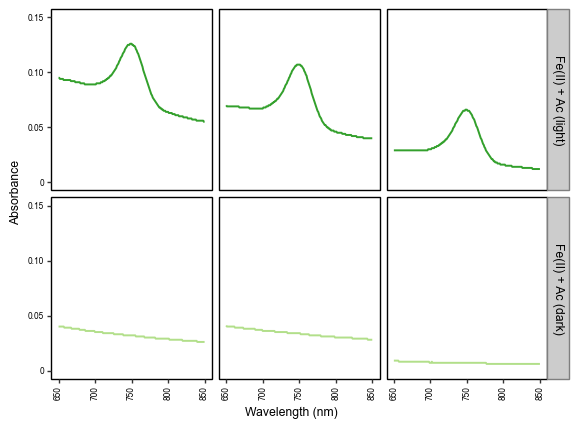

<ggplot: (385681298)>

In [7]:
spectrum_plot = (ggplot(plotting_data, aes(x='Wavelength (nm)', y='Absorbance'))
                + geom_path(aes(group='Sample', colour='Treatment'), size=0.8, alpha=1)
                + scale_colour_manual(values=['#33a02c', '#b2df8a'])
                + theme_bw()
                + facet_grid('Treatment ~ Replicate', scales='fixed')
                + theme(panel_grid=element_blank(),
                       text=element_text(colour='black', family='Arial'),
                       panel_border=element_rect(colour='black'),
                       axis_title=element_text(size=8.8),
                       axis_text=element_text(size=6),
                       axis_text_x=element_text(angle=90),
                       strip_background_x=element_blank(),
                       strip_text_x=element_blank())
                + scale_y_continuous(breaks=[0,0.05,0.1,0.15], limits=[0,0.15])
                + guides(colour=None)
                + ylab('Absorbance')
                )

spectrum_plot

In [8]:
spectrum_plot.save('light_dark_spectra_replicates.pdf', width=75, height=40, units='mm', verbose=False)

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packag